In [35]:
import os
import sys
import requests
import zipfile
from tqdm import tqdm  
import fluidfoam
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from src.config import DNS_DATA_DIR
from src.utils.data_utils import download_and_extract_data
from src.config import OPENFOAM_DATA_DIR
from src.utils.openFoamUtils import is_numeric_dir, read_wall_shear_stress_with_regex

def figsize(scale, nplots = 1):
    fig_width_pt = 452.96                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": r"\usepackage[utf8x]{inputenc}"  # Adjust this for your LaTeX preamble
                   r"\usepackage[T1]{fontenc}"      # Use T1 Font encoding for better font rendering
}
plt.rcParams.update(pgf_with_latex)

# Download and extract the turbulence statistics data from Van der A et al. (2018)
zenodo_url = "https://zenodo.org/records/1095116/files/20180620_Turbulence_statistics.zip?download=1"
data_dir = download_and_extract_data(zenodo_url, DNS_DATA_DIR)
print(f"Data available at: {data_dir}")

# List the extracted files to verify
print("\nExtracted files:")
for root, dirs, files in os.walk(data_dir, topdown=True):
    # Limit directory depth to avoid excessive output
    if root.count(os.sep) - data_dir.count(os.sep) > 1:
        continue
        
    for name in dirs[:5]:  # Show only first 5 directories
        print(f"Directory: {os.path.join(root, name)}")
    if len(dirs) > 5:
        print(f"... and {len(dirs) - 5} more directories")
        
    for name in files[:5]:  # Show only first 5 files
        print(f"File: {os.path.join(root, name)}")
    if len(files) > 5:
        print(f"... and {len(files) - 5} more files")

ZIP file already exists at /home/fredrik/Documents/Tensor_basis_neural_networks_for_unsteady_flow_prediction/data/dns/turbulence_statistics.zip
Files already extracted at /home/fredrik/Documents/Tensor_basis_neural_networks_for_unsteady_flow_prediction/data/dns/vanDerA2018
Data available at: /home/fredrik/Documents/Tensor_basis_neural_networks_for_unsteady_flow_prediction/data/dns/vanDerA2018

Extracted files:
Directory: /home/fredrik/Documents/Tensor_basis_neural_networks_for_unsteady_flow_prediction/data/dns/vanDerA2018/data_exp
Directory: /home/fredrik/Documents/Tensor_basis_neural_networks_for_unsteady_flow_prediction/data/dns/vanDerA2018/data_num
File: /home/fredrik/Documents/Tensor_basis_neural_networks_for_unsteady_flow_prediction/data/dns/vanDerA2018/README.txt
File: /home/fredrik/Documents/Tensor_basis_neural_networks_for_unsteady_flow_prediction/data/dns/vanDerA2018/data_exp/EXPRE1155_2C.nc
File: /home/fredrik/Documents/Tensor_basis_neural_networks_for_unsteady_flow_predictio

In [36]:
simulations = {'Re846': {'Re': 846, 'viscosity': 1.029e-6, 'wave_period': 7, 'stokes_layer_thickness': 0.00151, 'max_streamwise_velocity': 0.57},
               'Re1155': {'Re': 1155, 'viscosity': 1.029e-6, 'wave_period': 7, 'stokes_layer_thickness': 0.0015141948719309033, 'max_streamwise_velocity': 0.79},
               'Re1475': {'Re': 1475, 'viscosity': 1.029e-6, 'wave_period': 7, 'stokes_layer_thickness': 0.00151, 'max_streamwise_velocity': 1}}
sim = simulations['Re1155']
Re = sim['Re']
viscosity = sim['viscosity']
wave_period = sim['wave_period']
stokes_layer_thickness = sim['stokes_layer_thickness']
max_streamwise_velocity = sim['max_streamwise_velocity']
delta_t = 707

case_path = OPENFOAM_DATA_DIR+f"/kOmega/Re{Re}"
rans_path = OPENFOAM_DATA_DIR+f"/kOmega/Re{Re}"
dns_path = OPENFOAM_DATA_DIR+f"/kFrozen/Re{Re}"
tbnn_path = OPENFOAM_DATA_DIR+f"/tbnn/Re{Re}"
time_dirs = [d for d in os.listdir(case_path) if os.path.isdir(os.path.join(case_path, d)) and is_numeric_dir(d) and d != "0"]
time_dirs.sort(key=float)

In [37]:
data = {'t': [],
        'urans': [],'udns': [], 'utbnn': [],
        'krans': [],'kdns': [], 'ktbnn': [],
        'Rrans': [],'Rdns': [], 'Rtbnn': [],
        'tau0tbnn': [],'tau0rans': [],'tau0dns': []}
for time_step in time_dirs:
    data['t'].append(float(time_step))
    data['urans'].append(fluidfoam.readvector(rans_path, time_step, 'U', verbose=False)[0,:])
    data['udns'].append(fluidfoam.readvector(dns_path, time_step, 'Udns', verbose=False)[0,:])

    data['krans'].append(fluidfoam.readscalar(rans_path, time_step, 'k', verbose=False))
    data['kdns'].append(fluidfoam.readscalar(dns_path, time_step, 'kdns', verbose=False))

    data['Rrans'].append(fluidfoam.readsymmtensor(rans_path, time_step, 'turbulenceProperties:R', verbose=False))
    data['Rdns'].append(fluidfoam.readsymmtensor(dns_path, time_step, 'Rdns', verbose=False))

    data['utbnn'].append(fluidfoam.readvector(tbnn_path, f'{float(time_step)+delta_t:.2f}'.rstrip('0').rstrip('.'), 'U', verbose=False)[0,:])
    data['ktbnn'].append(fluidfoam.readscalar(tbnn_path, f'{float(time_step)+delta_t:.2f}'.rstrip('0').rstrip('.'), 'k', verbose=False))
    data['Rtbnn'].append(fluidfoam.readsymmtensor(tbnn_path, f'{float(time_step)+delta_t:.2f}'.rstrip('0').rstrip('.'), 'turbulenceProperties:R', verbose=False))
    data['tau0tbnn'].append(read_wall_shear_stress_with_regex(os.path.join(tbnn_path, f'{float(time_step)+delta_t:.2f}'.rstrip('0').rstrip('.'), "wallShearStress")))

    data['tau0rans'].append(read_wall_shear_stress_with_regex(os.path.join(rans_path, time_step, "wallShearStress")))

for key, value in data.items():
    data[key] = np.array([np.nan if elem is None else elem for elem in value])
x, y, z = fluidfoam.readmesh(case_path, verbose=False)

<>:125: DeprecationWarning: invalid escape sequence '\o'
<>:125: DeprecationWarning: invalid escape sequence '\o'
/tmp/ipykernel_3071293/3462240099.py:125: DeprecationWarning: invalid escape sequence '\o'
  mlines.Line2D([], [], color=colors[1], linestyle=linestyles[1], linewidth=2.5, label='$k-\omega$ model'),


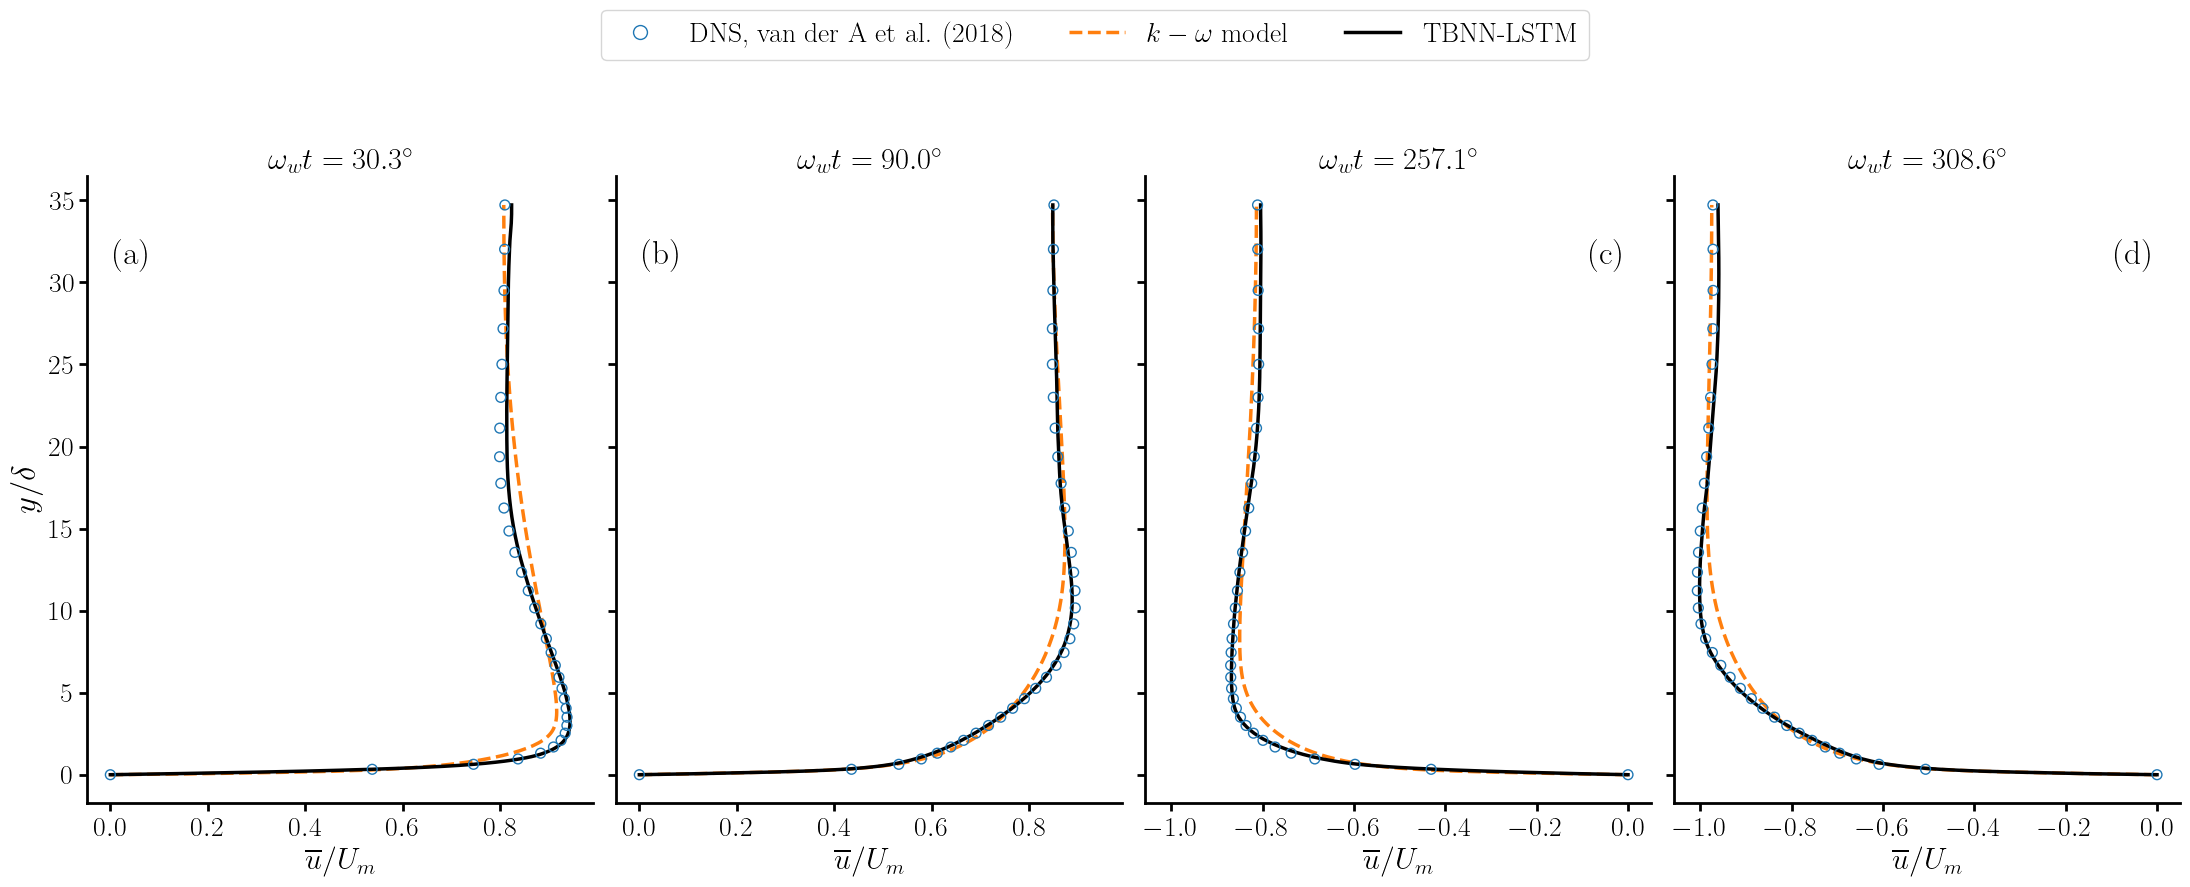

In [38]:
# Define colors and line styles
colors = ['#1f77b4', '#ff7f0e', '#000000', '#2ca02c']
linestyles = ['-', '--', '-']

# Selected time indices for plotting
time_indices = [59, 175, 500, 600]

sigma = 2 * np.pi / 7
dt = 0.01
dns_step = 5
u_max = max_streamwise_velocity
# Convert sigma * t to degrees for subplot titles
sigma_t_in_degrees = (np.array(time_indices) * sigma * dt) * (180 / np.pi)

# Subplot labels
subplot_labels = ["(a)", "(b)", "(c)", "(d)"]

fig, ax = plt.subplots(1, len(time_indices), figsize=(22, 8), sharey=True)

for idx, time_index in enumerate(time_indices):
    # DNS data with boundary point (u=0 at y=0)
    u_dns = data['udns'][time_index] / u_max
    y_dns = y / stokes_layer_thickness
    u_dns_bc = np.concatenate(([0.0], u_dns))
    y_dns_bc = np.concatenate(([0.0], y_dns))

    ax[idx].scatter(
        u_dns_bc[::dns_step],
        y_dns_bc[::dns_step],
        facecolor='none',
        edgecolor=colors[0],
        zorder=5,
        s=50
    )

    # RANS data
    u_rans = data['urans'][time_index] / u_max
    u_rans_bc = np.concatenate(([0.0], u_rans))
    y_rans_bc = np.concatenate(([0.0], y_dns))

    ax[idx].plot(
        u_rans_bc,
        y_rans_bc,
        linestyle=linestyles[1],
        color=colors[1],
        linewidth=2.5
    )

    # TBNN data
    u_tbnn = data['utbnn'][time_index] / u_max
    u_tbnn_bc = np.concatenate(([0.0], u_tbnn))
    y_tbnn_bc = np.concatenate(([0.0], y_dns))

    ax[idx].plot(
        u_tbnn_bc,
        y_tbnn_bc,
        linestyle=linestyles[2],
        color=colors[2],
        linewidth=2.5
    )

    # Axis styling
    ax[idx].set_xlabel(r"$\overline{u}/U_{m}$", fontsize=22, fontweight='bold')
    ax[idx].tick_params(axis='both', labelsize=20, width=2, length=6)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['right'].set_visible(False)
    ax[idx].spines['left'].set_linewidth(2)
    ax[idx].spines['bottom'].set_linewidth(2)

    # Set the subplot title (without the (a)/(b)/(c)/(d) part)
    ax[idx].set_title(
        rf"$\omega_w t = {sigma_t_in_degrees[idx]:.1f}^\circ$",
        fontsize=22, fontweight='bold'
    )

    # Decide label position based on subplot index
    if idx < 2:
        # (a), (b) top-left
        x_text, ha_val = 0.05, 'left'
    else:
        # (c), (d) top-right
        x_text, ha_val = 0.95, 'right'
    
    # Place the text label
    ax[idx].text(
        x_text, 0.9,                  # (x, y) in axes fraction
        subplot_labels[idx],
        transform=ax[idx].transAxes,
        fontsize=24,
        fontweight='bold',
        va='top',
        ha=ha_val
    )

# Y-axis styling
ax[0].set_ylabel(r"$y/\delta$", fontsize=24, fontweight='bold')

# Force x-axis to include zero if needed
for a in ax:
    xmin, xmax = a.get_xlim()
    if xmin > 0:
        a.set_xlim(left=0)

xlim_ab = [min(ax[0].get_xlim()[0], ax[1].get_xlim()[0]), 
           max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])]
if xlim_ab[0] > 0:
    xlim_ab[0] = 0

# Group 2: subplots (c) and (d)
xlim_cd = [min(ax[2].get_xlim()[0], ax[3].get_xlim()[0]), 
           max(ax[2].get_xlim()[1], ax[3].get_xlim()[1])]
if xlim_cd[0] > 0:
    xlim_cd[0] = 0

# Apply the grouped limits
ax[0].set_xlim(xlim_ab)
ax[1].set_xlim(xlim_ab)
ax[2].set_xlim(xlim_cd)
ax[3].set_xlim(xlim_cd)

# Custom legend
handles = [
    mlines.Line2D([], [], color=colors[0], linestyle='none', marker='o',
                  markerfacecolor='none', markeredgecolor=colors[0], markersize=10, label='DNS, van der A et al. (2018)'),
    mlines.Line2D([], [], color=colors[1], linestyle=linestyles[1], linewidth=2.5, label='$k-\omega$ model'),
    mlines.Line2D([], [], color=colors[2], linestyle=linestyles[2], linewidth=2.5, label='TBNN-LSTM')
]

fig.legend(handles=handles, loc='upper center', ncol=3, fontsize=20, bbox_to_anchor=(0.5, 1.12))
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
plt.savefig('../figures/velocity_profile.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../figures/velocity_profile.pdf', bbox_inches='tight', pad_inches=0.1)

plt.show()

<>:128: DeprecationWarning: invalid escape sequence '\o'
<>:128: DeprecationWarning: invalid escape sequence '\o'
/tmp/ipykernel_3071293/2646463385.py:128: DeprecationWarning: invalid escape sequence '\o'
  mlines.Line2D([], [], color=colors[1], linestyle=linestyles[1], linewidth=2.5, label='$k-\omega$ model'),


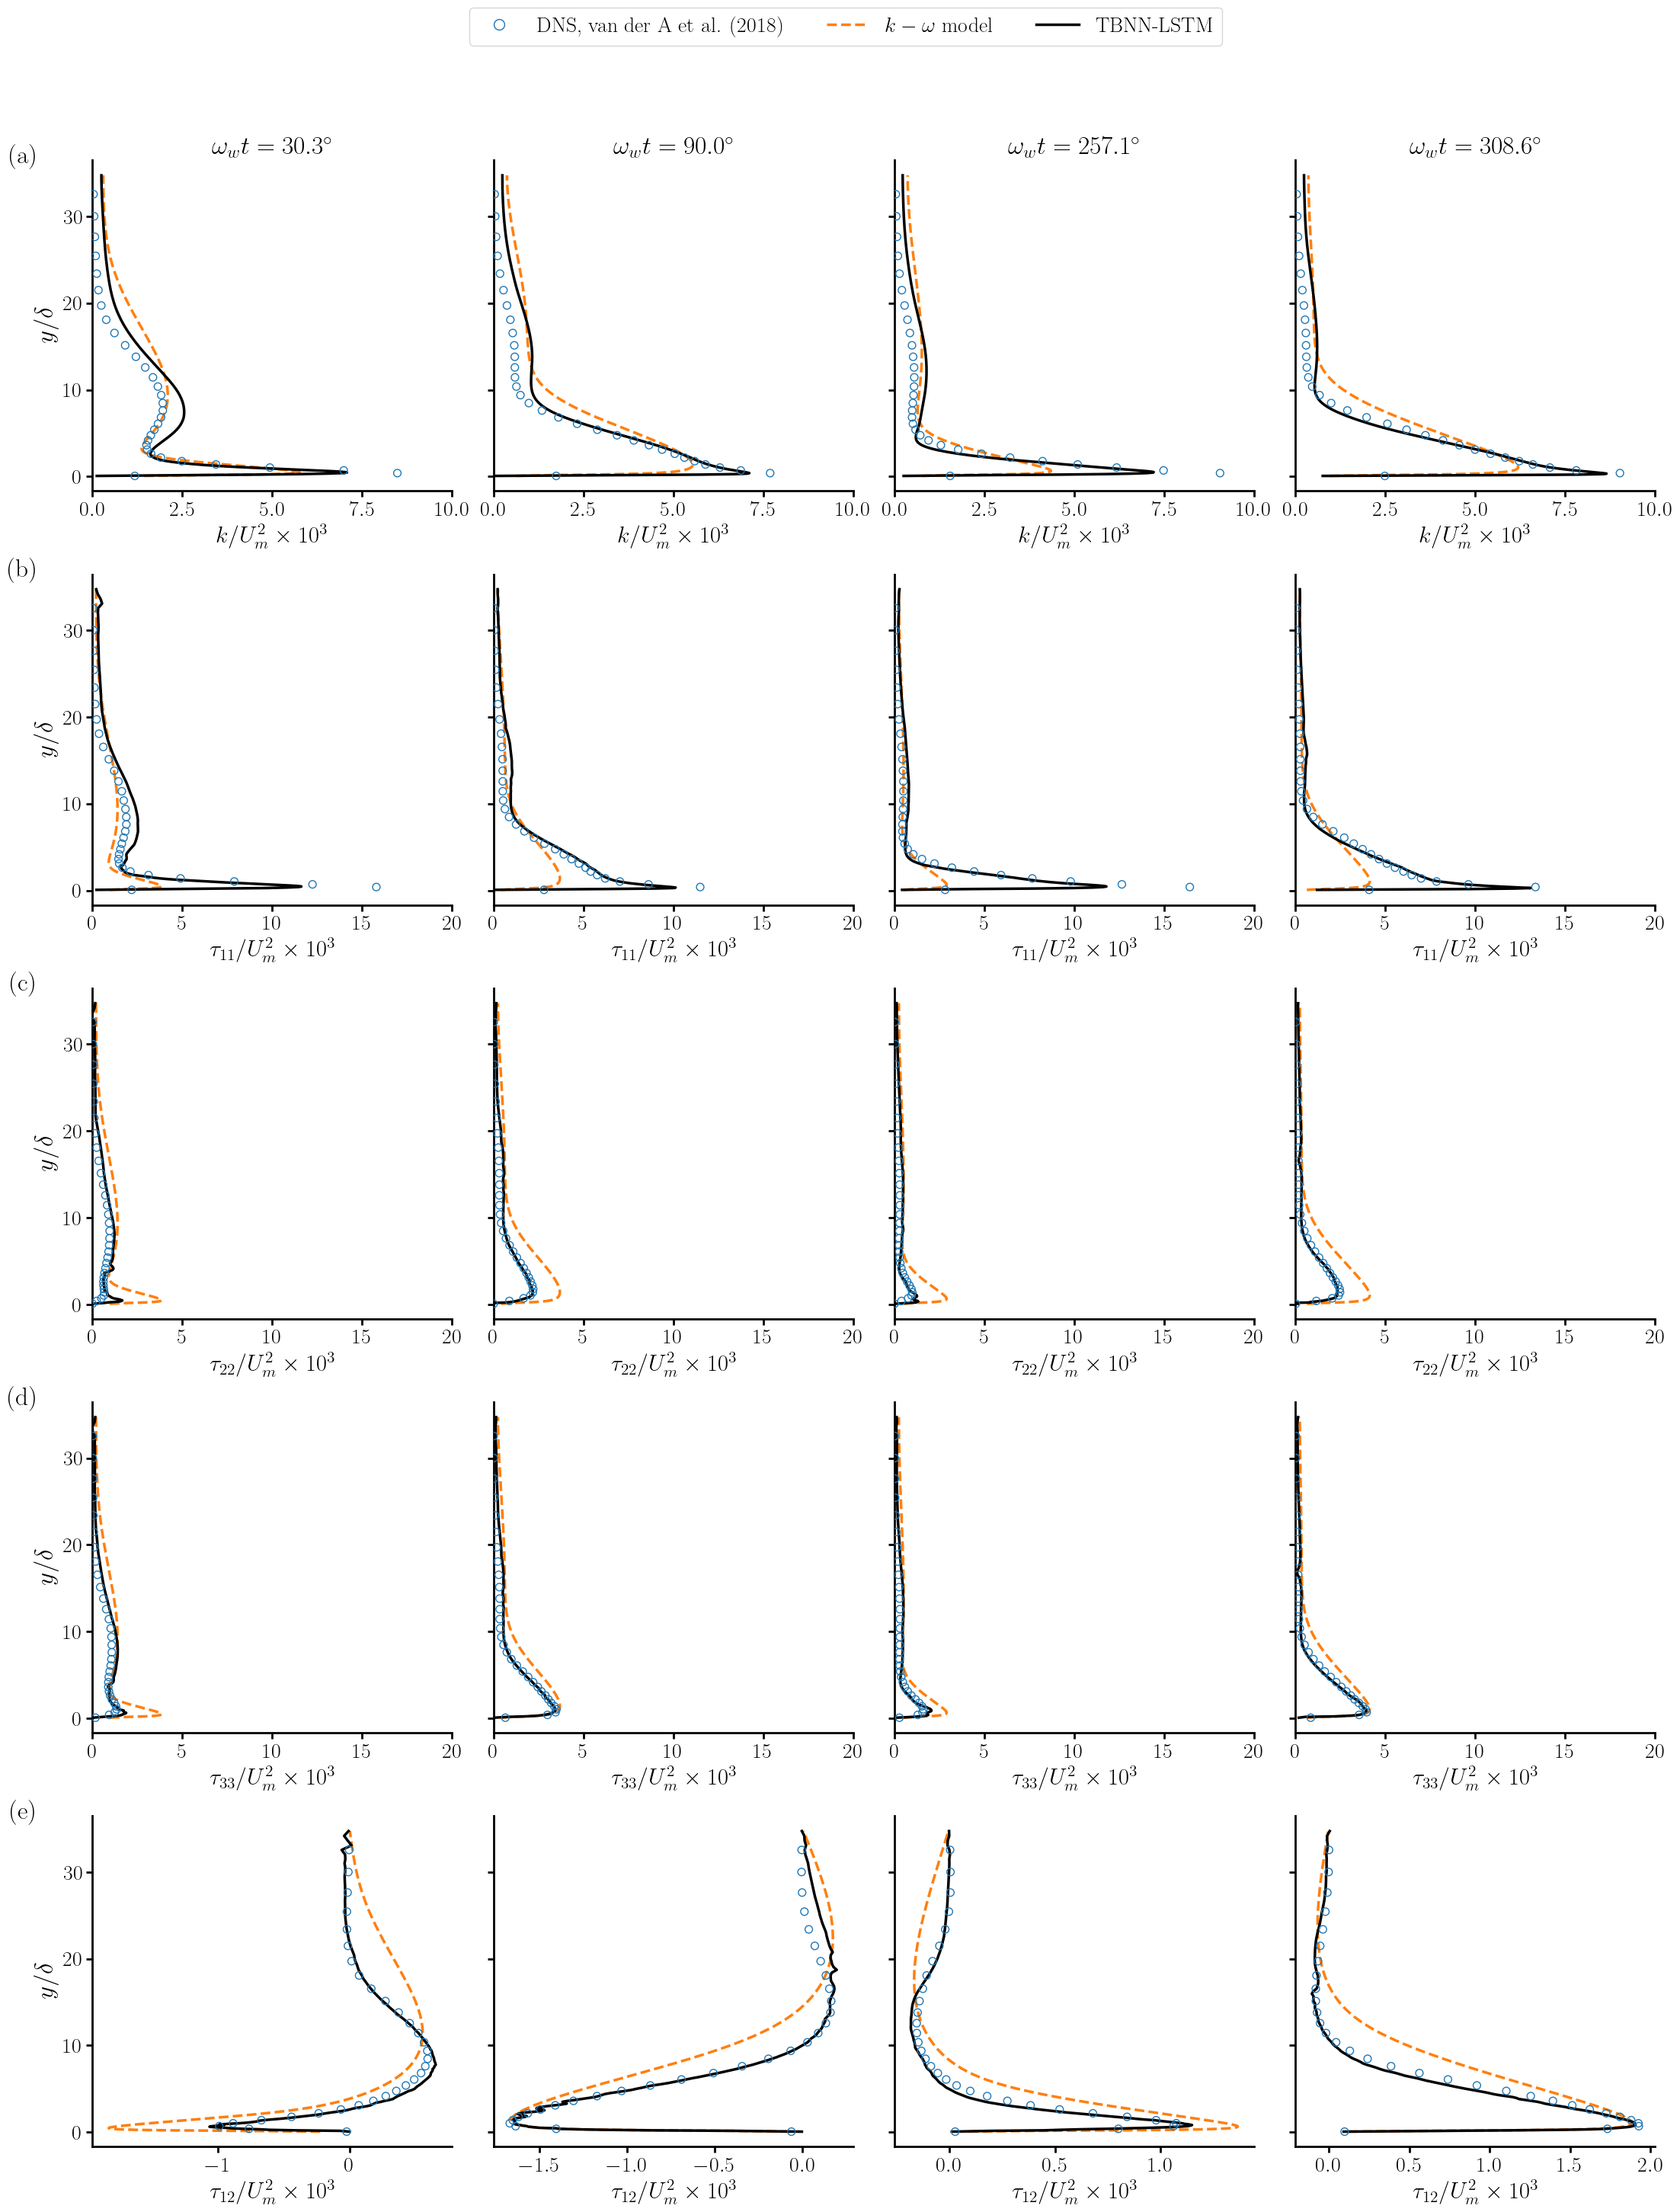

In [39]:
# Define colors and line styles
# Define colors and line styles
colors = ['#1f77b4', '#ff7f0e', '#000000', '#2ca02c']
linestyles = ['-', '--', '-']

# Selected time indices (same as previous plot)
time_indices = [59, 175, 500, 600]
#time_indices = [0, 3, 6, 8]


# Reorder tau12 to be last
variables = ['k', 'tau11', 'tau22', 'tau33', 'tau12']
xlabels = [r"$k/U_m^2 \times 10^3$", 
           r"$\tau_{11}/U_m^2 \times 10^3$", 
           r"$\tau_{22}/U_m^2 \times 10^3$", 
           r"$\tau_{33}/U_m^2 \times 10^3$", 
           r"$\tau_{12}/U_m^2 \times 10^3$"]

subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']

# Compute x-axis limits for tau11, k, and tau12
tau11_min, tau11_max = np.inf, -np.inf
k_min, k_max = np.inf, -np.inf
tau12_min, tau12_max = np.inf, -np.inf

for time_index in time_indices:
    # For tau11 (index 0)
    current_min = np.min(data['Rdns'][time_index][0] / u_max**2 * 1e3)
    current_max = np.max(data['Rdns'][time_index][0] / u_max**2 * 1e3)
    tau11_min = min(tau11_min, current_min)
    tau11_max = max(tau11_max, current_max)
    
    # For k
    k_current_min = np.min(data['kdns'][time_index] / u_max**2 * 1e3)
    k_current_max = np.max(data['kdns'][time_index] / u_max**2 * 1e3)
    k_min = min(k_min, k_current_min)
    k_max = max(k_max, k_current_max)
    
    # For tau12 (index 1)
    tau12_current_min = np.min(data['Rdns'][time_index][1] / u_max**2 * 1e3)
    tau12_current_max = np.max(data['Rdns'][time_index][1] / u_max**2 * 1e3)
    tau12_min = min(tau12_min, tau12_current_min)
    tau12_max = max(tau12_max, tau12_current_max)

# Round min and max to nearest nice values
tau11_min = np.floor(tau11_min / 5) * 5  # Round down to nearest 5
tau11_max = np.ceil(tau11_max / 5) * 5   # Round up to nearest 5

k_min = np.floor(k_min / 5) * 5  # Round down to nearest 5
k_max = np.ceil(k_max / 5) * 5   # Round up to nearest 5

tau12_min = np.floor(tau12_min / 5) * 5  # Round down to nearest 5
tau12_max = np.ceil(tau12_max / 5) * 5   # Round up to nearest 5

# Generate equally spaced x-ticks
num_ticks = 5  # Number of tick marks
tau_ticks = np.linspace(tau11_min, tau11_max, num_ticks)
k_ticks = np.linspace(k_min, k_max, num_ticks)
tau12_ticks = np.linspace(tau12_min, tau12_max, num_ticks)

# Set plot size and aesthetics
fig, ax = plt.subplots(len(variables), len(time_indices), figsize=(22, 28), sharey=True)

for col, time_index in enumerate(time_indices):
    sigma_t_deg = (time_index * sigma * dt) * (180 / np.pi)  # Convert to degrees

    for row, var in enumerate(variables):
        current_ax = ax[row, col]

        # Select the correct data based on variable type
        if var == 'k':
            dns_data = data['kdns'][time_index] / u_max**2 * 1e3  # Scale by 10^3
            rans_data = data['krans'][time_index] / u_max**2 * 1e3
            tbnn_data = data['ktbnn'][time_index] / u_max**2 * 1e3
        else:
            index = {'tau11': 0, 'tau12': 1, 'tau22': 3, 'tau33': 5}[var]
            dns_data = data['Rdns'][time_index][index] / u_max**2 * 1e3  # Scale by 10^3
            rans_data = data['Rrans'][time_index][index] / u_max**2 * 1e3
            tbnn_data = data['Rtbnn'][time_index][index] / u_max**2 * 1e3

        # DNS
        #current_ax.plot(dns_data, y / stokes_layer_thickness, linestyle='-', color=colors[0], linewidth=2.5)
        current_ax.scatter(dns_data[::dns_step], (y / stokes_layer_thickness)[::dns_step],
                           facecolor='none',edgecolor=colors[0], zorder=5, s=50)
      

        # RANS
        current_ax.plot(rans_data, y / stokes_layer_thickness, linestyle='--', color=colors[1], linewidth=2.5)

        # TBNN
        current_ax.plot(tbnn_data, y / stokes_layer_thickness, linestyle='-', color=colors[2], linewidth=2.5)

        # Axis styling
        current_ax.set_xlabel(xlabels[row], fontsize=22, fontweight='bold')
        current_ax.grid(False)
        current_ax.spines['top'].set_visible(False)
        current_ax.spines['right'].set_visible(False)
        current_ax.spines['left'].set_linewidth(2)
        current_ax.spines['bottom'].set_linewidth(2)
        current_ax.tick_params(axis='both', labelsize=20, width=2, length=6)

        # Apply consistent x-axis limits & ticks for different variables
        if var == 'k':
            current_ax.set_xlim(k_min, k_max)
            current_ax.set_xticks(k_ticks)
        elif var in ['tau11', 'tau22', 'tau33']:
            current_ax.set_xlim(tau11_min, tau11_max)
            current_ax.set_xticks(tau_ticks)
        

        # Add subplot labels (a, b, c, d, e)
        if col == 0:
            current_ax.text(-0.15, 1.05, subplot_labels[row], transform=current_ax.transAxes,
                            fontsize=24, fontweight='bold', va='top', ha='right')

        # Add title for each subplot at the top row
        if row == 0:
            current_ax.set_title(rf"$\omega_w t = {sigma_t_deg:.1f}^\circ$", fontsize=24, fontweight='bold')

# Y-axis styling
for r in range(len(variables)):
    ax[r, 0].set_ylabel(r"$y/\delta$", fontsize=24, fontweight='bold')

# Custom legend
handles = [
    mlines.Line2D([], [], color=colors[0], linestyle='none', marker='o',
                  markerfacecolor='none',  markeredgecolor=colors[0], markersize=10, label='DNS, van der A et al. (2018)'),
    mlines.Line2D([], [], color=colors[1], linestyle=linestyles[1], linewidth=2.5, label='$k-\omega$ model'),
    mlines.Line2D([], [], color=colors[2], linestyle=linestyles[2], linewidth=2.5, label='TBNN-LSTM')
]

fig.legend(handles=handles, loc='upper center', ncol=3, fontsize=20, bbox_to_anchor=(0.5, 1.04))

plt.tight_layout(rect=[0, 0, 1, 0.98])

# Save plot
plt.savefig('../figures/full_profile_comparison.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../figures/full_profile_comparison.pdf', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

<>:95: DeprecationWarning: invalid escape sequence '\o'
<>:95: DeprecationWarning: invalid escape sequence '\o'
/tmp/ipykernel_3071293/2385441720.py:95: DeprecationWarning: invalid escape sequence '\o'
  mlines.Line2D([], [], color=colors[1], linestyle=linestyles[1], linewidth=2.5, label='$k-\omega$ model'),


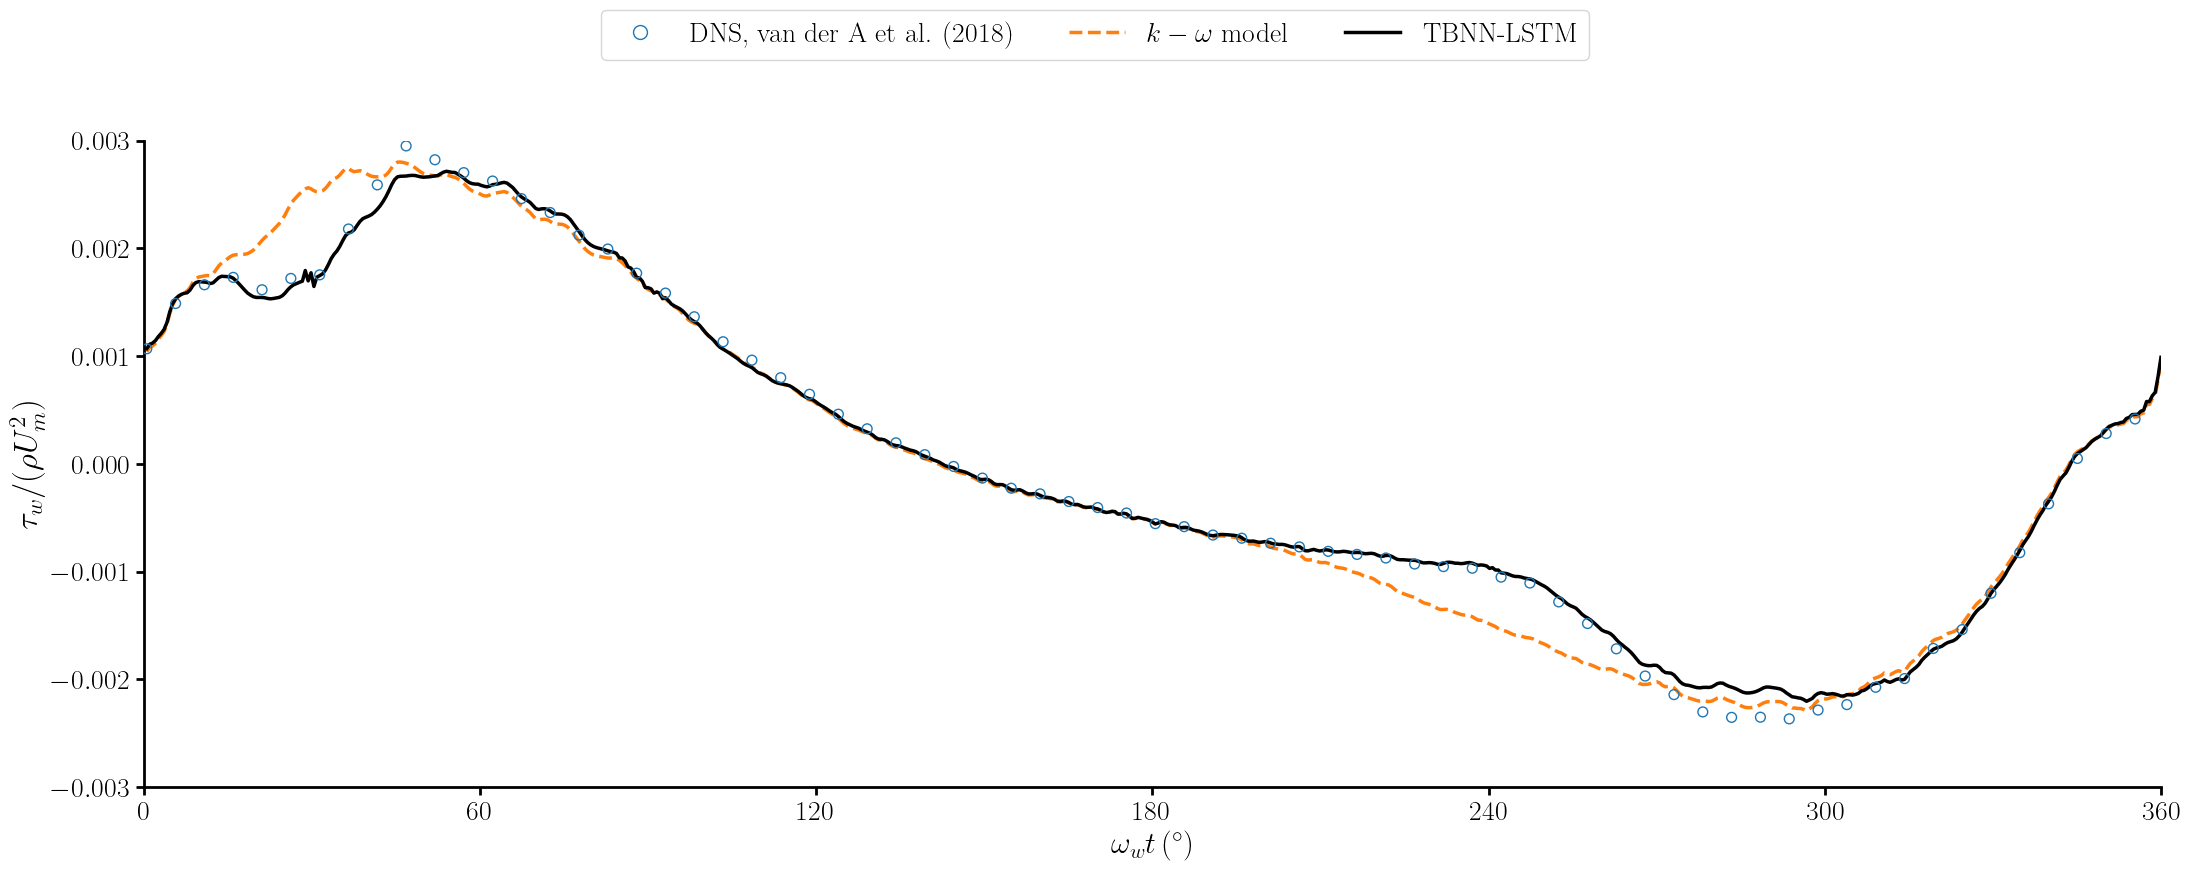

In [40]:
# Read the different components of DNS data
import netCDF4 as nc
dnsPath = DNS_DATA_DIR+f'/vanDerA2018/data_num/DNSRE{Re}'
dns_data = {}
plot_tbnn = True
with nc.Dataset(f"{dnsPath}_u.nc", 'r') as dns_u:

    u2 = dns_u['u2'][:]*max_streamwise_velocity ** 2 
    dns_data['u']= dns_u['u'][:]*max_streamwise_velocity
    dns_data['yu'] = np.squeeze(dns_u['yu'][:])*stokes_layer_thickness
    dns_data['u2'] = u2
with nc.Dataset(f"{dnsPath}_v.nc", 'r') as dns_v:
    v2 = dns_v['v2'][:]*max_streamwise_velocity ** 2
    dns_data['v2'] = v2 
    dns_data['yv'] = np.squeeze(dns_v['yv'][:])*stokes_layer_thickness
with nc.Dataset(f"{dnsPath}_w.nc", 'r') as dns_w:
    w2 = dns_w['w2'][:] *max_streamwise_velocity ** 2 
    dns_data['w2'] = w2
    dns_data['yw'] = np.squeeze(dns_w['yw'][:])*stokes_layer_thickness
with nc.Dataset(f"{dnsPath}_uv.nc", 'r') as dns_uv:
    uv = dns_uv['uv'][:] *max_streamwise_velocity ** 2 
    dns_data['uv'] = uv

# Calculate turbulent kinetic energy
k = 0.5 * (u2 + v2 + w2)
dns_data['k'] = k

# Create Reynolds stress tensor (assuming uw and vw components are available)
# tau = [[u2, uv, uw], [vu, v2, vw], [wu, wv, w2]]
# Assuming symmetry of the Reynolds stress tensor (vu = uv, wu = uw, wv = vw)
tau = np.array([[u2, uv, np.zeros_like(u2)],  # uw component is assumed to be zero for simplicity
                [uv, v2, np.zeros_like(v2)],  # vw component is assumed to be zero for simplicity
                [np.zeros_like(w2), np.zeros_like(w2), w2]])
dns_data['tau'] = tau.transpose(2, 3, 0, 1)

# Constants
viscosity = 1.029e-6  # Dynamic viscosity in m^2/s
rho = 1  # Density in kg/m^3
u = dns_data['u']
yu = dns_data['yu']
# Compute wall shear stress
dy = yu[1] - yu[0]  # Distance between first and second points in y-direction
du_dy = (u[:, 1] - u[:, 0]) / dy  # Velocity gradient at the wall

# Wall shear stress at each time step (DNS)
tau_0 = viscosity * du_dy  
tau_0_nd = tau_0 / (rho * u_max**2)  # Non-dimensionalized

# Convert time axis to σt (degrees)
sigma_t = (data['t'] - 1400) * sigma * (180 / np.pi)

# Set figure size
fig, ax = plt.subplots(1, 1, figsize=(22, 8))

# Plot DNS data
#ax.plot(sigma_t, tau_0_nd, linestyle=linestyles[0], color=colors[0], linewidth=2.5, label="DNS")
ax.scatter(sigma_t[::10], tau_0_nd[::10],facecolor='none',edgecolor=colors[0], zorder=5, s=50)  # Scatter points

# Plot RANS data
ax.plot(sigma_t, data['tau0rans'] / (-1 * u_max**2), linestyle=linestyles[1], color=colors[1], linewidth=2.5, label="RANS")

# Plot TBNN data if required
if plot_tbnn:
    ax.plot(sigma_t, data['tau0tbnn'] / (-1 * u_max**2), linestyle=linestyles[2], color=colors[2], linewidth=2.5, label="TBNN-LSTM")

# Set axis limits
# Set x-axis from 0 to 360 degrees
ax.set_xlim(0, 360)
ax.set_xticks(np.arange(0, 361, 60))  # Set ticks every 60 degrees

# Set symmetric y-axis limits
all_y_data = np.concatenate([tau_0_nd, data['tau0rans'] / (-1 * u_max**2)])
if plot_tbnn:
    all_y_data = np.concatenate([all_y_data, data['tau0tbnn'] / (-1 * u_max**2)])
y_max = np.max(np.abs(all_y_data))
# Round to the next 0.001
y_max = np.ceil(y_max * 1000) / 1000
ax.set_ylim(-y_max, y_max)
# Axis Labels
ax.set_xlabel(r"$\omega_w t \, (^\circ)$", fontsize=22, fontweight='bold')
ax.set_ylabel(r"$\tau_w / (\rho U_m^2)$", fontsize=24, fontweight='bold')

# Formatting
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(axis='both', labelsize=20, width=2, length=6)

# Custom legend (matching previous figures)
handles = [
    mlines.Line2D([], [], color=colors[0], linestyle='none', marker='o',
                  markerfacecolor='none',  markeredgecolor=colors[0], markersize=10, label='DNS, van der A et al. (2018)'),
    mlines.Line2D([], [], color=colors[1], linestyle=linestyles[1], linewidth=2.5, label='$k-\omega$ model'),
    mlines.Line2D([], [], color=colors[2], linestyle=linestyles[2], linewidth=2.5, label='TBNN-LSTM')
]

fig.legend(handles=handles, loc='upper center', ncol=3, fontsize=20, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
plt.savefig('../figures/wallshearstress_profile.png', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../figures/wallshearstress_profile.pdf', bbox_inches='tight', pad_inches=0.1)

# Show plot
plt.show()